In [1]:
import numpy as np
import scipy
from matplotlib import pyplot as plt
from numpy.random import default_rng

import astropy
import astropy.cosmology
from astropy import units as u

import Corrfunc
from Corrfunc.theory import DD
from Corrfunc.utils import convert_3d_counts_to_cf

# Utility functions

In [2]:
mock_dir = '/mount/sirocco1/ksf293/aemulator/mocks_nseries'

In [3]:
def load_mock(rlz, with_collisions=False):
    res = np.loadtxt(f'{mock_dir}/CutskyN{rlz}.rdzwc', unpack=True)
    # don't know what the 4th column is! fkp weight 
    # 5th column: 0, 1, 2 - weight 0 means collided.
    ra, dec, redshift, _, weight, redshift_colliding, id_colliding = res
    if with_collisions:
        idx_collided = np.where(weight==0)[0]
        print("N collided galaxies:", len(idx_collided))
        id_of_matched = np.array(id_colliding[idx_collided], dtype=int)
        # check - should be replacing the positions too? 
        ra[idx_collided] = ra[id_of_matched]
        dec[idx_collided] = dec[id_of_matched]
        redshift[idx_collided] = redshift[id_of_matched]
    return ra, dec, redshift

In [4]:
def load_random(factor=50):
    res = np.loadtxt(f'{mock_dir}/Nseries_cutsky_randoms_{factor}x_redshifts.dat', unpack=True)
    print(res.shape)
    ra, dec, redshift, *other = res
    return ra, dec, redshift

In [5]:
def spherical_to_cartesian(r, theta, phi):
    # theta and phi in radians
    x       =  r*np.cos(theta)*np.sin(phi)
    y       =  r*np.sin(theta)*np.sin(phi)
    z       =  r*np.cos(phi)
    return np.array([x, y, z])

In [6]:
def radec_to_cartesian(ra, dec, redshift, cosmo):
    theta = (ra)*np.pi/180
    phi = (dec+90)*np.pi/180
    
    # theta: [0, 2pi]
    # phi: [0, pi]
    print(theta.min(), theta.max())
    print(phi.min(), phi.max())
    
    # line-of-sight comoving distance
    distances_Mpc = cosmo.comoving_distance(redshift) 
    distances = distances_Mpc * cosmo.h # to Mpc/h
    
    x, y, z = spherical_to_cartesian(distances, theta, phi)
    return np.array([x, y, z])

# Load and plot mocks

In [7]:
ra, dec, redshift = load_mock(1)
ra_coll, dec_coll, redshift_coll = load_mock(1, with_collisions=True)

N collided galaxies: 43817


In [8]:
# check that the arrays are different the number of times there are collided gals
# maybe slightly diff bc of exact duplicates??
print(len(np.where(~(ra == ra_coll))[0]))
print(len(np.where(~(dec == dec_coll))[0]))
print(len(np.where(~(redshift == redshift_coll))[0]))

43761
43776
43760


Text(0.5, 1.0, 'NGC mock')

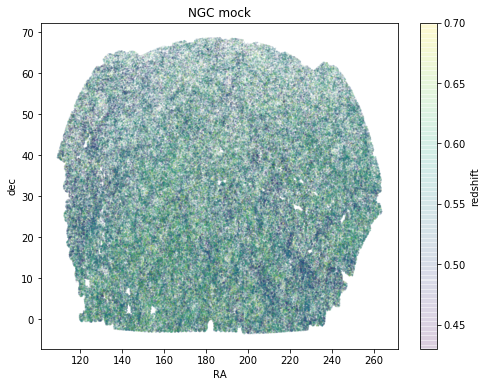

In [9]:
plt.figure(figsize=(8,6))
plt.scatter(ra, dec, c=redshift, s=0.1, alpha=0.1)
plt.colorbar(label='redshift')
plt.xlabel('RA')
plt.ylabel('dec')
plt.title('NGC mock')

In [10]:
ra_rand, dec_rand, redshift_rand = load_random(factor=10)
len(ra_rand)

(3, 6580488)


6580488

In [11]:
cosmo = astropy.cosmology.Planck15
print(cosmo)

FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)


In [12]:
x, y, z = radec_to_cartesian(ra, dec, redshift, cosmo)
print(x.min(), x.max())

1.9017454850251363 4.604495344020278
1.5076534560503954 2.7705295459634165
-1746.3062669444716 -109.64409785329028


In [13]:
x_rand, y_rand, z_rand = radec_to_cartesian(ra_rand, dec_rand, redshift_rand, cosmo)
print(x_rand.min(), x_rand.max())

1.9007434915015662 4.6063342229201805
1.5074010814405572 2.7706850547997695
-1746.4315459224006 -108.96017858809833


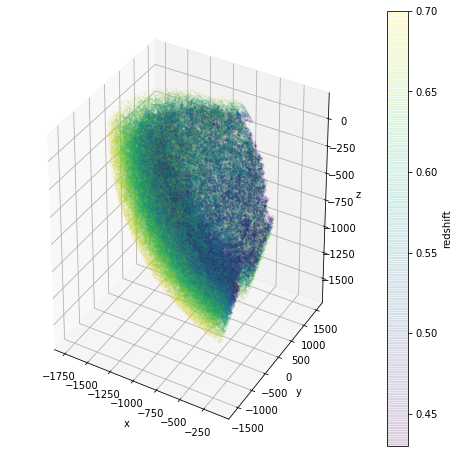

In [14]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
scat = ax.scatter(x, y, z, s=0.1, alpha=0.1, c=redshift)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
fig.colorbar(scat, label='redshift')

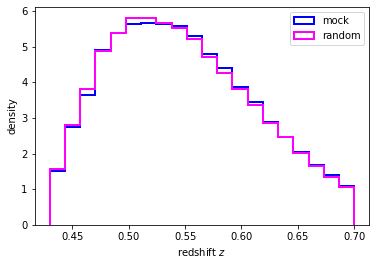

In [15]:
density = True
plt.hist(redshift, density=density, histtype='step', bins=20, lw=2, color='blue', label='mock')
plt.hist(redshift_rand, density=density, histtype='step', bins=20, lw=2, color='magenta', label='random')
plt.xlabel(r'redshift $z$')
plt.ylabel('density')
plt.legend()

## Measure xi

In [16]:
# nthreads = 1
# rmin, rmax = 20, 150
# bin_size = 5
# r_edges = np.arange(rmin, rmax+bin_size, bin_size)
# r_avg = 0.5 * (r_edges[1:] + r_edges[:-1])

In [17]:
# autocorr=1
# res_dd = DD(autocorr, nthreads, r_edges, x, y, z, periodic=False)

In [18]:
# autocorr=0
# res_dr = DD(autocorr, nthreads, r_edges, x, y, z,
#        X2=x_rand, Y2=y_rand, Z2=z_rand, periodic=False)

In [19]:
# autocorr=1
# res_rr = DD(autocorr, nthreads, r_edges, x_rand, y_rand, z_rand, periodic=False)

In [20]:
# N = len(x)
# N_rand = len(x_rand)

# xi = convert_3d_counts_to_cf(N, N, N_rand, N_rand,
#                                  res_dd, res_dr,
#                                  res_dr, res_rr)

In [21]:
# plt.figure(figsize=(8,6))
# plt.plot(r_avg, xi, color='blue', label=f'true')

# plt.xlabel('r (Mpc/h)')
# plt.ylabel(r'$\xi(r)$')
# plt.axhline(0, color='grey')
# plt.legend()

# Check completeness of random catalog spheres

In [22]:
def get_sphere_centers_cartesian(N_spheres, radius, x, y, z):

    x_min = np.min(x) - radius
    x_max = np.max(x) + radius
    y_min = np.min(y) - radius
    y_max = np.max(z) + radius
    z_min = np.min(z) - radius
    z_max = np.max(z) + radius

    rng = default_rng()
    x_spheres = rng.uniform(low=x_min, high=x_max, size=N_spheres)
    y_spheres = rng.uniform(low=y_min, high=y_max, size=N_spheres)
    z_spheres = rng.uniform(low=z_min, high=z_max, size=N_spheres)
    cents_spheres = np.array([x_spheres, y_spheres, z_spheres]).T

In [23]:
def get_sphere_centers(N_spheres, ra, dec, redshift):

    # should have buffer or something?
    ra_min = np.min(ra)
    ra_max = np.max(ra)
    dec_min = np.min(dec)
    dec_max = np.max(dec)
    redshift_min = np.min(redshift)
    redshift_max = np.max(redshift)
    
    rng = default_rng()
    ra_spheres = rng.uniform(low=ra_min, high=ra_max, size=N_spheres)
    dec_spheres = rng.uniform(low=dec_min, high=dec_max, size=N_spheres)
    redshift_spheres = rng.uniform(low=redshift_min, high=redshift_max, size=N_spheres)
    
    cents_spheres = radec_to_cartesian(ra_spheres, dec_spheres, redshift_spheres, cosmo)
    return cents_spheres.T

In [24]:
pos_rand = np.array([x_rand,y_rand,z_rand]).T
print(pos_rand.shape)
tree_rand = scipy.spatial.KDTree(pos_rand)

(6580488, 3)


In [25]:
radius = 10 #Mpc/h
N_spheres = 10000
cents_spheres = get_sphere_centers(N_spheres, ra_rand, dec_rand, redshift_rand)

1.9010940675142505 4.604813673044788
1.507440202048857 2.7704927204339493


In [26]:
idx_neighbors = tree_rand.query_ball_point(cents_spheres, radius)

In [27]:
n_insphere = np.array([len(idxs) for idxs in idx_neighbors])

In [28]:
print(len(n_insphere))
idx_nonzero = np.where(n_insphere!=0)[0]
print(len(idx_nonzero))

10000
8265


Text(0, 0.5, 'number of spheres')

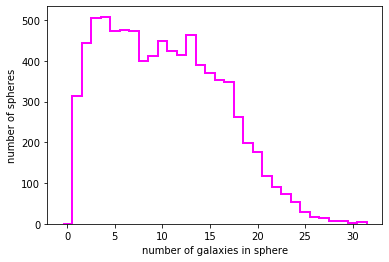

In [29]:
n_max = np.max(n_insphere)
bins = np.linspace(0, n_max, n_max+1)
_ = plt.hist(n_insphere[idx_nonzero], bins=bins, align='left', histtype='step', lw=2, color='magenta')
plt.xlabel('number of galaxies in sphere')
plt.ylabel('number of spheres')

In [30]:
V = 4/3*np.pi*radius**3
nbar = 2e-4
# nbar = N/V
print(f"Expected number of galaxies per sphere with r={radius} and nbar={nbar}: {nbar*V:.3f}")

Expected number of galaxies per sphere with r=10 and nbar=0.0002: 0.838


In [31]:
n_median = np.median(n_insphere[idx_nonzero])
print(n_median)

10.0


In [32]:
#completeness_thresh = 0.95 * n_median

# Measure density in mock

In [33]:
pos = np.array([x,y,z]).T
print(pos.shape)
tree = scipy.spatial.KDTree(pos)

(646667, 3)


In [34]:
idx_neighbors = tree.query_ball_point(cents_spheres, radius)

In [35]:
n_insphere = np.array([len(idxs) for idxs in idx_neighbors])
print(len(n_insphere))
idx_nonzero = np.where(n_insphere!=0)[0]
print(len(idx_nonzero))

10000
3449


Text(0, 0.5, 'number of spheres')

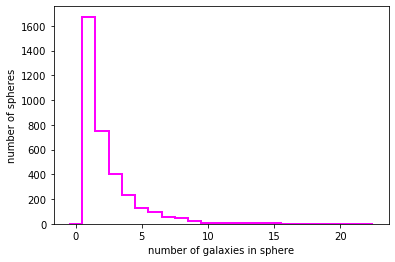

In [36]:
n_max = np.max(n_insphere)
bins = np.linspace(0, n_max, n_max+1)
_ = plt.hist(n_insphere[idx_nonzero], bins=bins, align='left', histtype='step', lw=2, color='magenta')
plt.xlabel('number of galaxies in sphere')
plt.ylabel('number of spheres')